# Modeling spike data with `multidms.jaxmodels`

In [135]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

In [136]:
functional_scores_fp = "../scaled_down_parameter_output/simulated_functional_scores.csv"
simu_mut_effects_fp = "../scaled_down_parameter_output/simulated_muteffects.csv"

replicate = "lib_1" # "lib_2" also available
func_score_type = "observed_phenotype" # "tight_bottle" or "loose_bottle" also available to add noise
do_truncate_nonsense = True # whether to truncate functional scores of nonsense mutations
output_dir = 'simulations_output' # directory to save output files

reference = 'h1' # 'h2' also available (but we simulated h1 to be the actual reference)
l2reg = 1e-4 # ridge regularization strength on beta's
fusionreg = 2.0 # fusion lasso regularization strength between conditional effects 
beta0_ridge = 100 # fusion ridge regularization strength on beta0's
block_iters = 1000 # max block coordinate descent iterations
block_tol = 1e-6 # convergence tolerance for block coordinate descent

ge_tol = 1e-5 # convergence tolerance for global epistasis optimization (Beta, and Beta0)
ge_maxiter = 1000 # max iterations for global epistasis optimization
ge_maxls = 40 # max line search steps for global epistasis optimization

cal_tol = 1e-4 # convergence tolerance for calibration, alpha
cal_maxiter = 1000 # max iterations for calibration, alpha
cal_maxls = 40 # max line search steps for calibration, alpha

loss_fn = "functional_score_loss" # "count_loss" also available, unless using observed_phenotype functional scores
beta0_init = { # initial intercepts for each segment
    "h1": 0.0,  
    "h2": 0.0  
}
alpha_init = { # initial calibration slope for each segment
    "h1": 6.0,
    "h2": 6.0
}
warmstart = False # Whether to warmstart the beta's using simple ml. TODO broken ?
beta_clip = (-10, 10) # clip beta's to this range during optimization, helps with stability

loss_kwargs = {"δ": 1.0} 

global_epistasis = "Sigmoid" # "Identity" also available

functional_score_min = -6 # truncate functional scores in training data to this range, before fitting
functional_score_max = 2 # truncate functional scores in training data to this range, before fitting
# pseudocount = 0. # we now use functional scores computed in simulated_validation.ipynb.
min_pre_count = 200 # minimum pre-selection read count to keep a variant, unless using observed_phenotype functional scores
min_post_count = 1 # minimum post-selection read count to keep a variant, unless using observed_phenotype functional scores

In [137]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [138]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [139]:
df = (
    pd.read_csv(
        functional_scores_fp,
        keep_default_na=True
    )
    .infer_objects()
    .assign(
        aa_substitutions = lambda x: x['aa_substitutions'].fillna('')
    )
    .assign(
        n_subs = lambda x: x['aa_substitutions'].str.split().str.len()
    )
    .rename(
        columns={
            "library": "replicate",
            "homolog": "condition",
        }
    )
)
df


/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_78217/123020786.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
2,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
3,lib_1,h1,N22W L49I,observed_phenotype,-5.121204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.817175,2
4,lib_1,h1,K21N,observed_phenotype,-0.032459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,4.402149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349861,lib_2,h2,T4C N22A E28V,tight_bottle,-0.872689,pre-selection,0.225674,17.0,19.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.016912,3
349862,lib_2,h2,L2S A10S E28L,tight_bottle,-0.428415,pre-selection,0.222853,15.0,23.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.329871,3
349863,lib_2,h2,T4H D18S,tight_bottle,-1.590687,pre-selection,0.332509,15.0,10.0,1631741.0,3329303.0,0.5,2.0,>1 nonsynonymous,0.215730,2
349864,lib_2,h2,T12P A20I V41E,tight_bottle,-3.564861,pre-selection,0.976092,14.0,2.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,-1.403989,3


<Axes: >

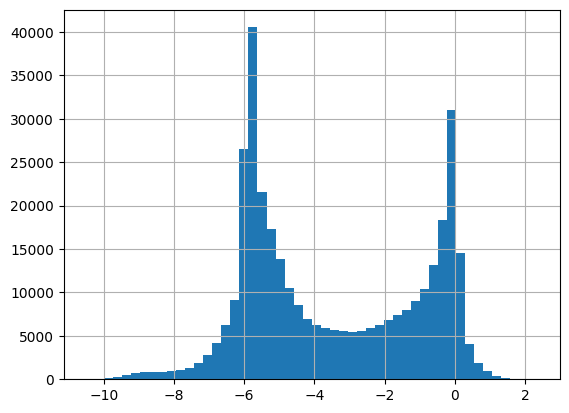

In [140]:
df.func_score.hist(bins=50)

In [141]:
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
2,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
3,lib_1,h1,N22W L49I,observed_phenotype,-5.121204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.817175,2
4,lib_1,h1,K21N,observed_phenotype,-0.032459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,4.402149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349861,lib_2,h2,T4C N22A E28V,tight_bottle,-0.872689,pre-selection,0.225674,17.0,19.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.016912,3
349862,lib_2,h2,L2S A10S E28L,tight_bottle,-0.428415,pre-selection,0.222853,15.0,23.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.329871,3
349863,lib_2,h2,T4H D18S,tight_bottle,-1.590687,pre-selection,0.332509,15.0,10.0,1631741.0,3329303.0,0.5,2.0,>1 nonsynonymous,0.215730,2
349864,lib_2,h2,T12P A20I V41E,tight_bottle,-3.564861,pre-selection,0.976092,14.0,2.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,-1.403989,3


In [142]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
2,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
3,lib_1,h1,N22W L49I,observed_phenotype,-5.121204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.817175,2
4,lib_1,h1,K21N,observed_phenotype,-0.032459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,4.402149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87531,lib_1,h2,C31R V42C,observed_phenotype,0.150661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.978748,2
87532,lib_1,h2,F1K P25D,observed_phenotype,-3.990509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-0.833197,2
87533,lib_1,h2,R13P L17Y G35N C37E Y47W,observed_phenotype,-5.689555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-3.902328,5
87534,lib_1,h2,N3R H24S V26G,observed_phenotype,-4.223353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.024447,3


In [143]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.000000
1,h1,lib_1,A10*,1,0.0,0.0,-5.919686
2,h1,lib_1,A10* C26K E27I M29R S46I,5,0.0,0.0,-5.959841
3,h1,lib_1,A10* C26L,2,0.0,0.0,-5.932902
4,h1,lib_1,A10* C26P W40T P43F,4,0.0,0.0,-5.959762
...,...,...,...,...,...,...,...
58475,h2,lib_1,Y47T G48S,2,0.0,0.0,-5.799976
58476,h2,lib_1,Y47T L49E,2,0.0,0.0,-4.684547
58477,h2,lib_1,Y47V,1,0.0,0.0,0.013736
58478,h2,lib_1,Y47V E50R,2,0.0,0.0,-0.128890


### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function. Note that the "observed_phenotype" functional score targets are taken directly from the sigmoidal mapping of latent phenotype in the simulations, and thus there are no actual counts simulated for this dataset.

In [144]:
if func_score_type != "observed_phenotype":
    g = sns.relplot(
        x=df.pre_count[df.aa_substitutions != ""],
        y=df.post_count[df.aa_substitutions != ""],
        col=df.condition[df.aa_substitutions != ""],
        s=10, alpha=0.1,
        height=3, aspect=1,
        clip_on=False,
        )
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xscale("symlog", linthresh=1, linscale=0.5)
    plt.yscale("symlog", linthresh=1, linscale=0.5)

    for ax in g.axes.flat:
        condition = ax.get_title().split(" = ")[1]
        df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
        df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
        ax.axvline(min_pre_count, color="red", linestyle="--")
        ax.axhline(min_post_count, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

In [145]:
df.shape

(58480, 7)

### Mutation number filtering

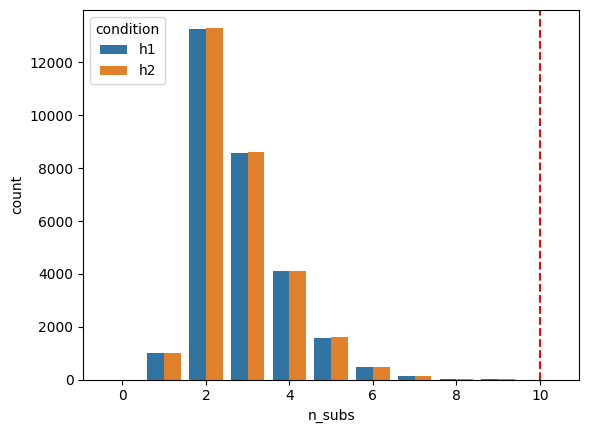

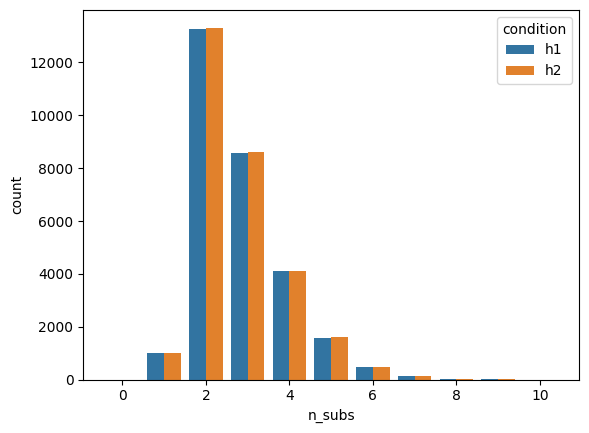

In [146]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [147]:
df.shape

(58480, 7)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [148]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [149]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

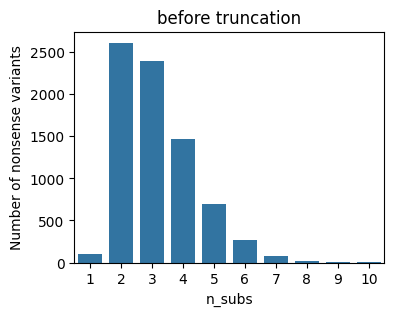

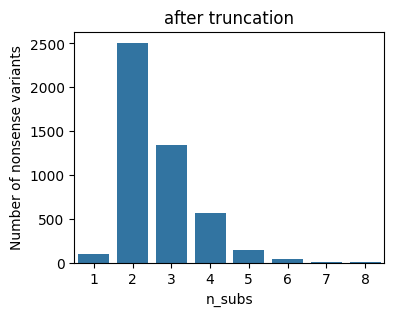

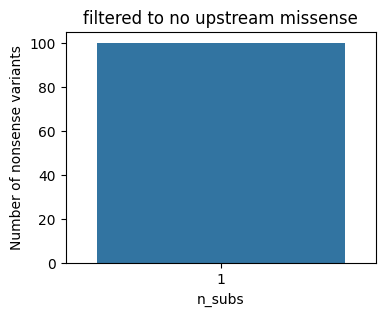

In [150]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_78217/2072519273.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


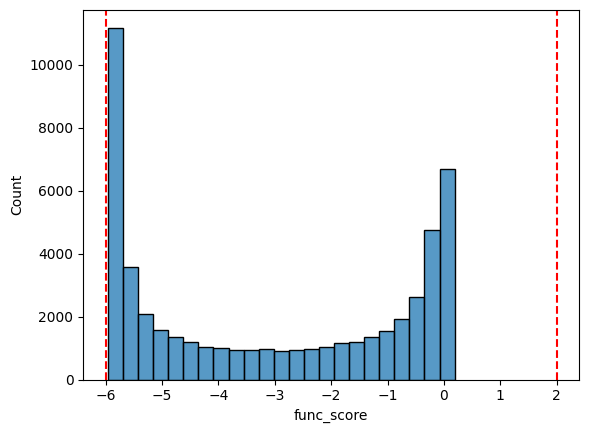

In [151]:
# NOTE: we no longer recompute functional scores.
# df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

# def group_wt_ref(df_group):
#     wts = df_group.query("aa_substitutions == ''")
#     assert wts.shape[0] == 1, wts
#     df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
#     return df_group

# df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

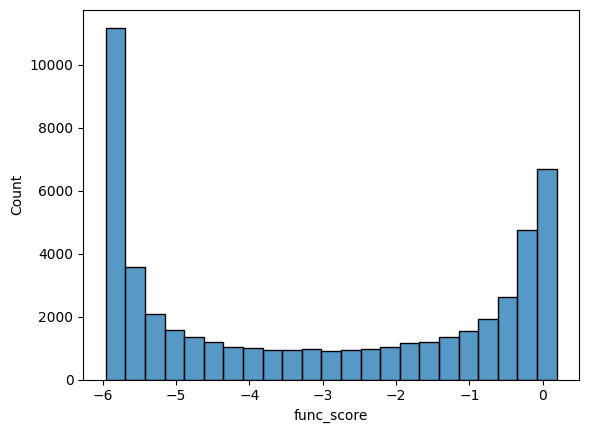

In [152]:
sns.histplot(df.func_score)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [153]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Create a `jaxmodels.Data` object, containing the array data

In [154]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[1000],
  X=BCOO(int8[25434, 1000], nse=69678),
  functional_scores=f64[25434],
  pre_count_wt=f64[],
  post_count_wt=f64[],
  pre_counts=f64[25434],
  post_counts=f64[25434]
)

In [155]:
data_sets

{'h1': Data(
   x_wt=i8[1000],
   X=BCOO(int8[25434, 1000], nse=69678),
   functional_scores=f64[25434],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[25434],
   post_counts=f64[25434]
 ),
 'h2': Data(
   x_wt=i8[1000],
   X=BCOO(int8[25506, 1000], nse=310092),
   functional_scores=f64[25506],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[25506],
   post_counts=f64[25506]
 )}

In [156]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.0
27740,h2,lib_1,,0,0.0,0.0,0.0


In [157]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


0.0
0.0
0.0
0.0


In [158]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

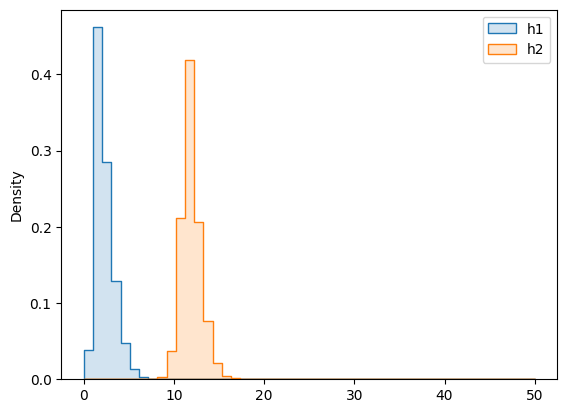

In [159]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

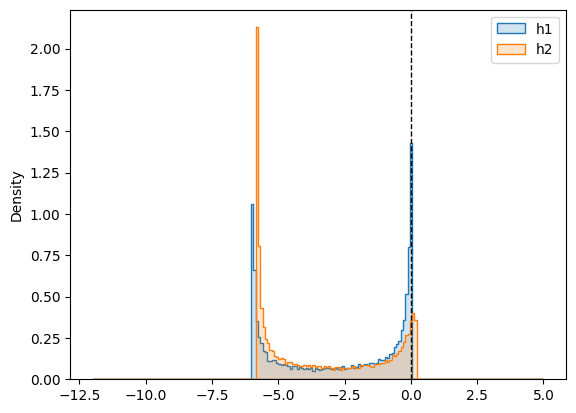

In [160]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [161]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    warmstart=warmstart,
    beta0_init=beta0_init,
    beta_clip_range=beta_clip,
    alpha_init=alpha_init,
    beta0_ridge=beta0_ridge
    )

iter 1:
  calibration block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
  β0 block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: β0=0.00
    h2: β0=0.00
  β_nonbundle: error=9.57e-06, stepsize=4.1e+03, iter=551
  β_bundle: error=9.58e-06, stepsize=8.0e+00, iter=697
  h2 sparsity=27.5%
  obj=2.10e-01
  objective_error=7.90e-01
iter 2:
  calibration block: error=6.66e-05, stepsize=6.4e+01, iter=25
    h1: α=10.00, θ=1.00
    h2: α=6.30, θ=1.00
  β0 block: error=8.36e-06, stepsize=8.0e+00, iter=21
    h1: β0=0.09
    h2: β0=-0.12
  β_nonbundle: error=8.73e-04, stepsize=2.6e+02, iter=1000
  β_bundle: error=9.15e-06, stepsize=8.0e+00, iter=315
  h2 sparsity=13.6%
  obj=8.03e-02
  objective_error=1.30e-01
iter 3:
  calibration block: error=6.77e-05, stepsize=3.2e+01, iter=15
    h1: α=10.84, θ=1.00
    h2: α=6.52, θ=1.00
  β0 block: error=3.02e-06, stepsize=8.0e+00, iter=11
    h1: β0=0.16
    h2: β0=-0.12
  β_nonbundle: error=6.02e-04, stepsiz

## Loss trajectory

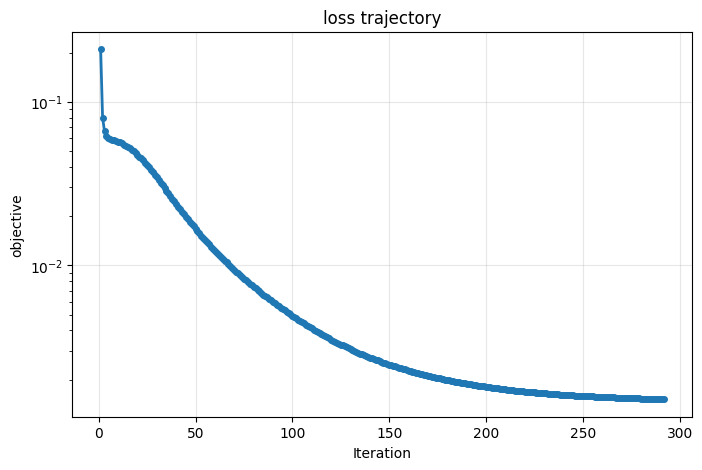

Final loss: 0.001517
Total iterations: 292


In [162]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

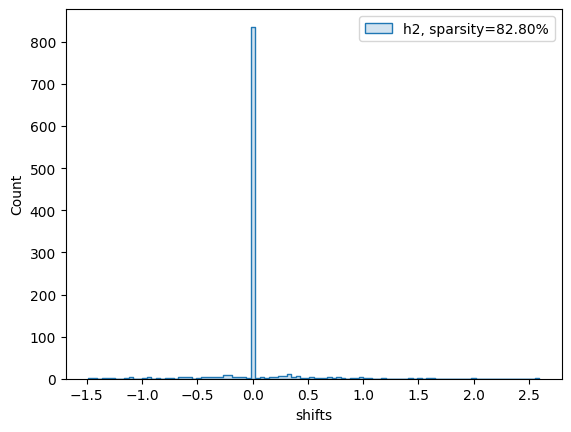

In [163]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [164]:
simu_mut_effects = pd.read_csv(simu_mut_effects_fp, keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


Find ground truth sparsity

In [165]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


(810, 1000, 0.81)

Functional score correlations

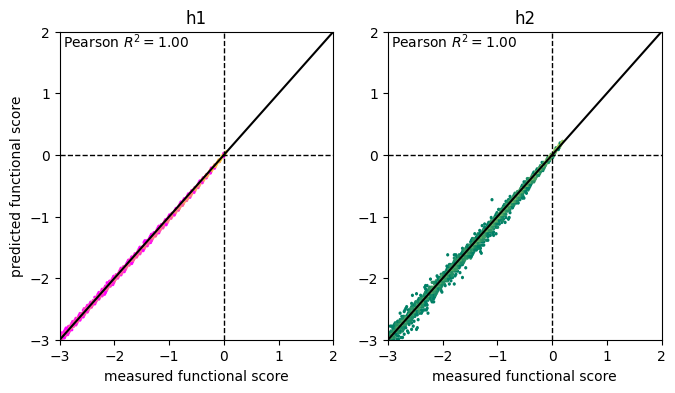

In [166]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

In [167]:
data_sets["h2"].x_wt.sum()

Array(10, dtype=int64)

In [168]:
model.φ["h2"]

Latent(β0=f64[], β=f64[1000])

In [169]:
(model.φ["h2"].β * data_sets["h2"].x_wt).sum() 

Array(-1.38341712, dtype=float64)

In [170]:
model.φ["h2"].β0

Array(4.65299787, dtype=float64)

h1 4.8142144182265945
h2 3.269580755467416


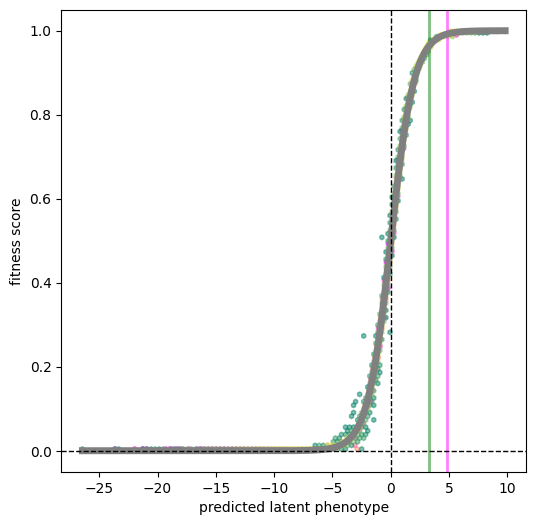

In [171]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
# plot the global epistasis function

for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    print(d, φ_pred_wt)
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=100, alpha=0.5)

φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
# plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

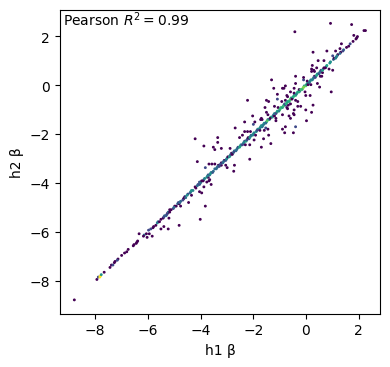

In [172]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [173]:
model.α

{'h1': Array(6.03434922, dtype=float64),
 'h2': Array(6.05322939, dtype=float64)}

Distribution of $\beta$

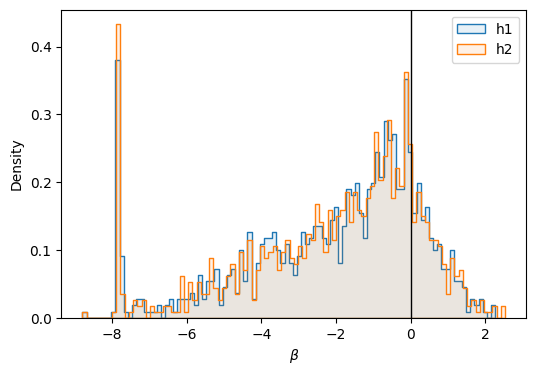

In [174]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [175]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2
0,F1A,F,1,A,83,84
1,F1C,F,1,C,37,39
2,F1D,F,1,D,55,56
3,F1E,F,1,E,50,50
4,F1G,F,1,G,102,101
...,...,...,...,...,...,...
995,E50T,E,50,T,103,102
996,E50V,E,50,V,111,107
997,E50W,E,50,W,28,28
998,E50Y,E,50,Y,37,36


In [176]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(1000, (25434, 1000))

In [177]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,
F1A,83,84,-1.945163,-1.945163,0.0
F1C,37,39,-0.394269,-0.394269,0.0
F1D,55,56,-2.822004,-2.822004,0.0
F1E,50,50,-1.448666,-1.448666,0.0
F1G,102,101,-4.570403,-4.570403,0.0
...,...,...,...,...,...
E50T,103,102,-0.908533,-0.908533,0.0
E50V,111,107,-0.938010,-0.938010,0.0
E50W,28,28,-1.132400,-1.132400,0.0


In [178]:
mutations_df.beta_h1.isna().sum()

np.int64(0)

In [179]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False
F1C,-0.417888,False,0.0,-0.417888,F,F,False
F1D,-2.928096,False,0.0,-2.928096,F,F,False
F1E,-1.516192,False,0.0,-1.516192,F,F,False
F1G,-4.732575,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False
E50V,-0.989250,False,0.0,-0.989250,E,E,False
E50W,-1.192453,False,0.0,-1.192453,E,E,False


In [180]:
simu_mut_effects.shape

(1000, 7)

In [181]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

set()

In [182]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False,83,84,-1.945163,-1.945163,0.0
F1C,-0.417888,False,0.0,-0.417888,F,F,False,37,39,-0.394269,-0.394269,0.0
F1D,-2.928096,False,0.0,-2.928096,F,F,False,55,56,-2.822004,-2.822004,0.0
F1E,-1.516192,False,0.0,-1.516192,F,F,False,50,50,-1.448666,-1.448666,0.0
F1G,-4.732575,False,0.0,-4.732575,F,F,False,102,101,-4.570403,-4.570403,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False,103,102,-0.908533,-0.908533,0.0
E50V,-0.989250,False,0.0,-0.989250,E,E,False,111,107,-0.938010,-0.938010,0.0
E50W,-1.192453,False,0.0,-1.192453,E,E,False,28,28,-1.132400,-1.132400,0.0


In [183]:
merged_df.shape

(1000, 12)

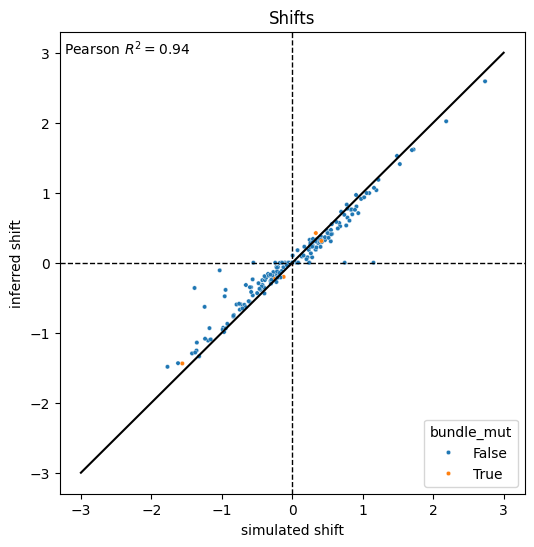

In [184]:
# plot inferred shifts vs simulated shifts for h2

plt.figure(figsize=(6, 6))
x = merged_df['simulated_shift']#.query("mutation.str.contains('19')")["simulated_shift"]
y = merged_df['shift_h2']#.query("mutation.str.contains('19')")["shift_h2"]
# plt.scatter(x, y, alpha=1, s=10)
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
sns.scatterplot(
    merged_df,#.query("mutation.str.contains('19')"), 
    x="simulated_shift", 
    y="shift_h2", 
    alpha=1, 
    s=10,
    hue="bundle_mut"
    )
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

In [185]:
merged_df = merged_df.assign(shift_error_h2 = (merged_df["simulated_shift"] - merged_df["shift_h2"]))
merged_df.query("bundle_mut")["shift_error_h2"].sum()

np.float64(0.0003230970269209321)

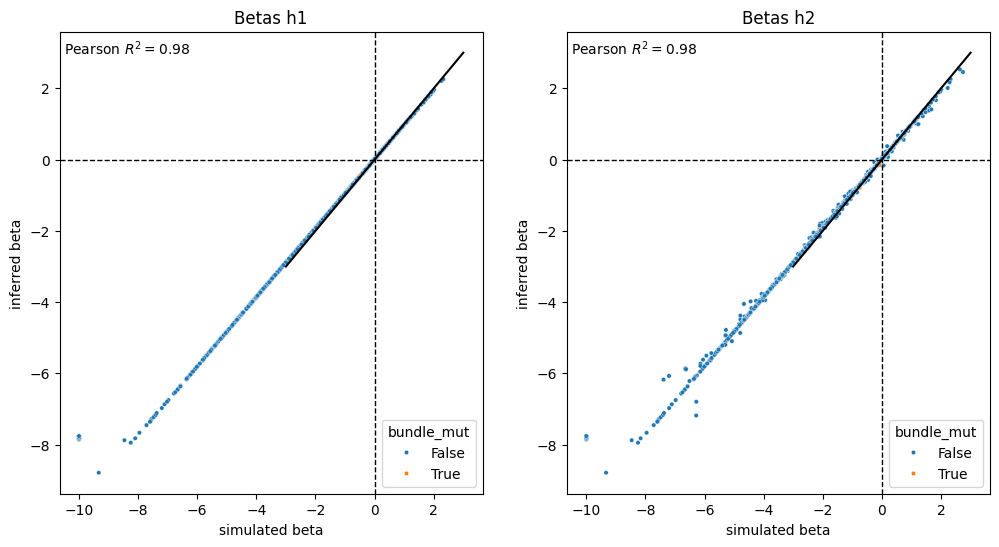

In [186]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    # plt.scatter(x, y, alpha=1, s=10)
    sns.scatterplot(merged_df, x=f"simulated_beta_{d}", y=f"beta_{d}", alpha=1, s=10, hue="bundle_mut")
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")

In [187]:
merged_df = merged_df.assign(abs_beta_error_h2 = (merged_df["simulated_beta_h2"] - merged_df["beta_h2"]).abs())
merged_df.sort_values("abs_beta_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,shift_error_h2,abs_beta_error_h2
mutation,,,,,,,,,,,,,,
E50*,-10.000000,False,0.000000,-10.000000,E,E,False,1,1,-7.759181,-7.759181,0.000000,0.000000,2.240819
L49*,-10.000000,False,0.000000,-10.000000,L,L,False,1,1,-7.759181,-7.759181,0.000000,0.000000,2.240819
Y42*,-10.000000,False,0.000000,-10.000000,Y,V,False,1,1,-7.760792,-7.760792,0.000000,0.000000,2.239208
V39*,-10.000000,True,0.000000,-10.000000,V,V,False,1,1,-7.771677,-7.771677,0.000000,0.000000,2.228323
W40*,-10.000000,False,0.000000,-10.000000,W,W,False,1,1,-7.778779,-7.778779,0.000000,0.000000,2.221221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T4R,0.269428,False,0.000000,0.269428,T,T,False,124,122,0.270320,0.270320,0.000000,0.000000,0.000892
E50Q,0.181812,False,0.000000,0.181812,E,E,False,36,36,0.180922,0.180922,0.000000,0.000000,0.000890
S12H,-4.165298,True,0.217118,-3.948179,S,T,False,48,49,-4.025223,-3.947346,0.077877,0.139241,0.000833
